In [6]:

import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
import scipy.signal as signal
import librosa

sys.path.append("/Users/oscarjimenezbou/Library/Mobile Documents/com~apple~CloudDocs/Documents/University_projects/TDS"
                )

In [7]:
from scipy.io import wavfile
from utils import number_count_detector, convert_m4p_to_wav, export_numbers

In [20]:
people = ["oscar"]

Thresholds used: [1]
Threshold used: 0.01
Number of numbers detected: 16
Maximum amplitude: 0.9725581563453639


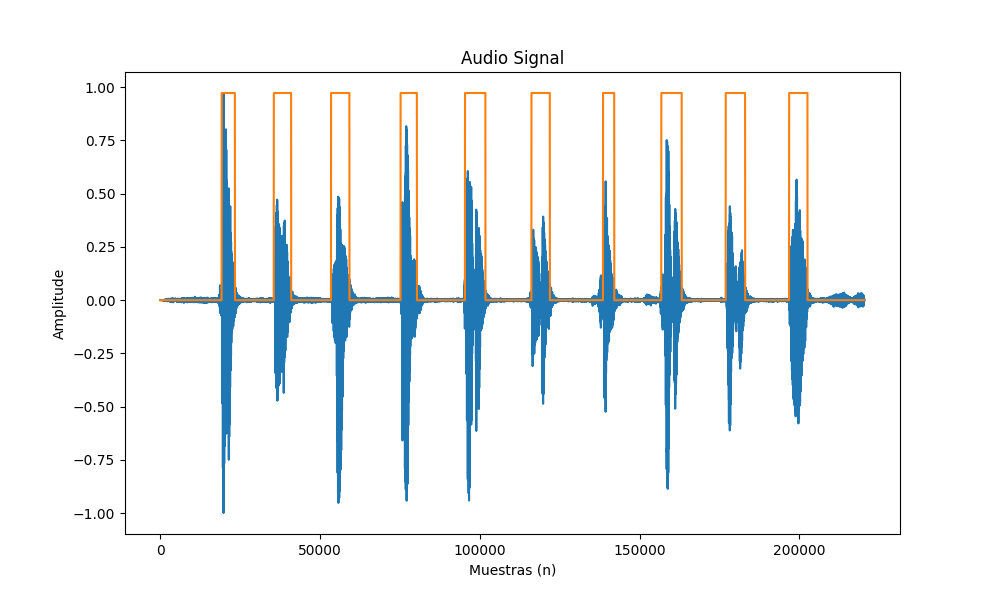

In [27]:
%matplotlib widget
for person in people:
    freq, audio_data = wavfile.read(person + ".wav")

    # convert mono, normalize and change the frecuency to 16kHz
    if len(audio_data.shape) > 1:
        audio_data = audio_data[:, 0]  

    audio_data = audio_data / np.max(np.abs(audio_data))  

    audio_data = signal.resample(audio_data, int(
        len(audio_data) * 16000 / freq))  

    window_size = 0.02  # 32ms
    window_overlap = 0  # No overlap

    voice = number_count_detector(
        audio_data,
        16000,
        window_size,
        window_overlap,
        count=10,
    )

    plt.figure(figsize=(10, 6))
    plt.plot(audio_data)
    plt.plot(voice * np.max(audio_data))
    plt.xlabel("Muestras (n)")
    plt.ylabel("Amplitude")
    plt.title("Audio Signal")
    plt.show()